In [ ]:
import tensorflow as tf

import numpy as np
import os
import time
import re
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu

Подгружаем библиотеку для оценки сгенерированного текста - https://pypi.org/project/language-tool-python/#description

In [ ]:
pip install --upgrade language_tool_python

In [ ]:
import language_tool_python
tool = language_tool_python.LanguageTool('ru-RU')  # use a local server (automatically set up), language English

Unzipping /tmp/tmp3fpfvl0s.zip to /root/.cache/language_tool_python.
Downloaded https://www.languagetool.org/download/LanguageTool-5.1.zip to /root/.cache/language_tool_python.


Импорт данных

In [ ]:
text = open("./text_with_dot.txt", 'rb').read().decode(encoding='utf-8')

In [ ]:
print(text[:500])

 Трудно поверить, но Новый год уже через месяц! Рассказываем, где купить подарки — и как вдобавок помочь благотворительным фондам (им это сейчас особенно нужно). nan.  Овощи и зелень убираем вниз, готовую еду — наверх. И еще 7 советов тем, кто хочет навести порядок в холодильнике.  Как закупаться на распродажах осознанно. Чтобы и удовольствие получить, и в плюсе остаться.  Вице-мэр Новосибирска показала макет городского катка. Раньше он выглядел как пенис. Да и сейчас тоже. nan.  В пустыне Юты н


Загружаем тестовые данные на которых будем проверять метрики

In [ ]:
df_test = pd.read_csv('test_data.csv')

Очищаем данные

In [ ]:
def text_clear(text):
  result = text.lower()
  result = re.sub(r'[!?]', '.', result)
  result = re.sub(r'[^а-яa-z\.\-\,]', ' ', result)
  result = re.sub(r"[\|/]", '', result) 
  result = re.sub(r"[\n]", ' ', result) 
  result = re.sub(r"[\r]", ' ', result) 
  result = re.sub(r"[nan]", ' ', result) 
  result = re.sub(r'\s+', ' ', result)
  result = re.sub(r' \.', '.', result)
  result = re.sub(r'\. \.', '.', result)
  result = re.sub(r'\.\.', '.', result)
  return result

text = text_clear(text)
len(text)

6804035

In [ ]:
print(text[:500])

 трудно поверить, но новый год уже через месяц. рассказываем, где купить подарки и как вдобавок помочь благотворительным фондам им это сейчас особенно нужно. овощи и зелень убираем вниз, готовую еду наверх. и еще советов тем, кто хочет навести порядок в холодильнике. как закупаться на распродажах осознанно. чтобы и удовольствие получить, и в плюсе остаться. вице-мэр новосибирска показала макет городского катка. раньше он выглядел как пенис. да и сейчас тоже. в пустыне юты нашли таинственный мета


Создаем список символов

In [ ]:
# The unique characters in the file
vocab_char = sorted(set(text))
print ('{} unique characters'.format(len(vocab_char)))

60 unique characters


Создаем список биграм

In [ ]:
vocab = []

for char_first in vocab_char:
  for char_second in vocab_char:
    vocab.append(char_first + char_second)

vocab = sorted(vocab)
print ('{} unique 2-gram'.format(len(vocab)))

3600 unique 2-gram


Формируем словари для кодирования биграмм

In [ ]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[text[c]+text[c+1]] for c in range(0, len(text)-1, 2)])

In [ ]:
print('{')
for char,_ in zip(char2idx, range(10)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '  ':   0,
  ' ,':   1,
  ' -':   2,
  ' .':   3,
  ' b':   4,
  ' c':   5,
  ' d':   6,
  ' e':   7,
  ' f':   8,
  ' g':   9,
  ...
}


Добавляем в датасет tf

In [ ]:
# The maximum length sentence we want for a single input in characters
seq_length = 128
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

 т
ру
дн
о 
по


In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

' трудно поверить, но новый год уже через месяц. рассказываем, где купить подарки и как вдобавок помочь благотворительным фондам им это сейчас особенно нужно. овощи и зелень убираем вниз, готовую еду наверх. и еще советов тем, кто хочет навести порядок в холо'
'дильнике. как закупаться на распродажах осознанно. чтобы и удовольствие получить, и в плюсе остаться. вице-мэр новосибирска показала макет городского катка. раньше он выглядел как пенис. да и сейчас тоже. в пустыне юты нашли таинственный металлический обелис'
'к. почти такой же, как в космической одиссее стэнли кубрика. пермь поражена коми-пермяцким вирусом, который обращает людей в зомби. спасти город может только колян. вышел трейлер абсурдной комедии реальные пацаны против зомби. как успокоить морского ежа. нап'
'ечатать ему шляпку на d-принтере.. житель колпино, захвативший шестерых детей, сдался полиции. в колпино отец шести детей заперся с ними в квартире и угрожает их убить. в челябинске сгорел автомобиль журналистки z k.

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  ' трудно поверить, но новый год уже через месяц. рассказываем, где купить подарки и как вдобавок помочь благотворительным фондам им это сейчас особенно нужно. овощи и зелень убираем вниз, готовую еду наверх. и еще советов тем, кто хочет навести порядок в хо'
Target data: 'рудно поверить, но новый год уже через месяц. рассказываем, где купить подарки и как вдобавок помочь благотворительным фондам им это сейчас особенно нужно. овощи и зелень убираем вниз, готовую еду наверх. и еще советов тем, кто хочет навести порядок в холо'


Разделение на части датасета для одновременного использования gpu

In [ ]:
# Batch size
BATCH_SIZE = 512

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 50000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((512, 128), (512, 128)), types: (tf.int64, tf.int64)>

Настройки, рассчитываем размер словаря и параметры кодирования, а также настройки слоев

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 512
# Number of RNN units
rnn_units_first = 1024
rnn_units_second = 512

Функция построения модели

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units_first, rnn_units_second, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units_first,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.LSTM(rnn_units_second,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(embedding_dim),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

Создаем модель

In [ ]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units_first=rnn_units_first,
  rnn_units_second=rnn_units_second,
  batch_size=BATCH_SIZE)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(512, 128, 3600) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (512, None, 512)          1843200   
_________________________________________________________________
lstm_58 (LSTM)               (512, None, 1024)         6295552   
_________________________________________________________________
lstm_59 (LSTM)               (512, None, 512)          3147776   
_________________________________________________________________
dense_58 (Dense)             (512, None, 512)          262656    
_________________________________________________________________
dense_59 (Dense)             (512, None, 3600)         1846800   
Total params: 13,395,984
Trainable params: 13,395,984
Non-trainable params: 0
_________________________________________________________________


Функция потерь, используем кроссэнтропию

In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

Prediction shape:  (512, 128, 3600)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       8.188727


Компилируем модель и указываем метод который будет использоваться при обучении

In [ ]:
model.compile(optimizer='adam', loss=loss)

Определяем функции, которые будут выполняться во время работы модели, на определенные события - это один стандартный, который будет сохранять модель после эпохи и второй, кастомный, который будет проверять две метрики(bleu и число ошибок после проверки библиотекой, основанной на правилах)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")


checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

class CheckCallback(tf.keras.callbacks.Callback):
    def __init__(self):
      super(MyCustomCallback, self).__init__()
      self.df_test_array_summary = pd.DataFrame()  # summary
      self.df_test_array = pd.DataFrame()  # texts

    def on_epoch_end(self, epoch, logs=None):
        model_last = build_model(vocab_size, embedding_dim, rnn_units_first, rnn_units_second, batch_size=1)
        model_last.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
        model_last.build(tf.TensorShape([1, None]))
        bleu_score_result = test_model_function(df_test, model_last, epoch, self.df_test_array)
        self.df_test_array = bleu_score_result[0]
        self.df_test_array_summary = self.df_test_array_summary.append({'epoch':epoch, 'bleu_score_mean':bleu_score_result[1], 'error_count_mean':bleu_score_result[2], 'loss_in_training':logs["loss"]},ignore_index=True)

Определим функции генерации текста

In [ ]:
def generate_text(model, start_string):
  #print('generate_text')
  #print(start_string)
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 300
  
  #print('1')
  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[start_string[c]+start_string[c+1]] for c in range(0, len(start_string)-1, 2)]
  input_eval = tf.expand_dims(input_eval, 0)
  #print('2')
  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1

  # Here batch size == 1
  model.reset_states()
  #print('3')
  for i in range(num_generate):
      #print('4')
      #print(input_eval)
      predictions = model(input_eval)
      # # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      #print('5')

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      #print('6')

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      #print('7')

      text_generated.append(idx2char[predicted_id])
      #print('8')
      #print(text_generated)
      if(idx2char[predicted_id].find('.') > -1):
        break
  #print('9')
  return (start_string + ''.join(text_generated))

Функция тестирования проводит цикл по массиву тестовых данных(пару дней новостей и сохраняет информацию на каждой эпохе)

In [ ]:
def test_model_function(df_test, model, epoch, df_test_array):
  # bleu score
  sum_score = 0
  # error score
  sum_error_count = 0
  count = 0
  for index, row in df_test.iterrows():
    test_text = text_clear(row['title'])
    test_text_split = test_text.split(' ')
    if len(test_text_split[0]) < 4:
      text_to_predict = test_text_split[0] + test_text_split[1]
    else:
      text_to_predict = test_text_split[0]
    if len(test_text_split) > 0 and (len(test_text_split[0]) > 0):

      # generate
      result_generate = generate_text(model, start_string=str(text_to_predict))
      
      #bleu
      score = sentence_bleu(test_text_split, result_generate.split())

      # check for error
      errors_in_generate_phrase = tool.check(result_generate)

      sum_score += score
      sum_error_count += len(errors_in_generate_phrase)
      count += 1

      df_test_array = df_test_array.append({'reference':test_text,'generate':result_generate,'bleu_score':score,'epoch':epoch,'lang_error':len(errors_in_generate_phrase), 'errors':errors_in_generate_phrase},ignore_index=True)

  return [df_test_array, (sum_score / count), (sum_error_count / count)]
  

Учим модель

In [ ]:
EPOCHS=25

In [ ]:
callback_training = CheckCallback()

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback,callback_training])

#history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/25
51/51 [==============================] - ETA: 0s - loss: 5.9887

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 90s 2s/step - loss: 5.9887
Epoch 2/25
51/51 [==============================] - ETA: 0s - loss: 5.7507WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 91s 2s/step - loss: 5.7507
Epoch 3/25
51/51 [==============================] - ETA: 0s - loss: 5.6734WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 87s 2s/step - loss: 5.6734
Epoch 4/25
51/51 [==============================] - ETA: 0s - loss: 5.1853WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 99s 2s/step - loss: 5.1853
Epoch 5/25
51/51 [==============================] - ETA: 0s - loss: 4.7025WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 99s 2s/step - loss: 4.7025
Epoch 6/25
51/51 [==============================] - ETA: 0s - loss: 4.4539WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 95s 2s/step - loss: 4.4539
Epoch 7/25
51/51 [==============================] - ETA: 0s - loss: 4.2378WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 94s 2s/step - loss: 4.2378
Epoch 8/25
51/51 [==============================] - ETA: 0s - loss: 4.0384WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 95s 2s/step - loss: 4.0384
Epoch 9/25
51/51 [==============================] - ETA: 0s - loss: 3.8533WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 90s 2s/step - loss: 3.8533
Epoch 10/25
51/51 [==============================] - ETA: 0s - loss: 3.6848WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 91s 2s/step - loss: 3.6848
Epoch 11/25
51/51 [==============================] - ETA: 0s - loss: 3.5388WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 98s 2s/step - loss: 3.5388
Epoch 12/25
51/51 [==============================] - ETA: 0s - loss: 3.4136WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 89s 2s/step - loss: 3.4136
Epoch 13/25
51/51 [==============================] - ETA: 0s - loss: 3.3064WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 91s 2s/step - loss: 3.3064
Epoch 14/25
51/51 [==============================] - ETA: 0s - loss: 3.2126WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 91s 2s/step - loss: 3.2126
Epoch 15/25
51/51 [==============================] - ETA: 0s - loss: 3.1333WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 95s 2s/step - loss: 3.1333
Epoch 16/25
51/51 [==============================] - ETA: 0s - loss: 3.0624WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 95s 2s/step - loss: 3.0624
Epoch 17/25
51/51 [==============================] - ETA: 0s - loss: 3.0017WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 97s 2s/step - loss: 3.0017
Epoch 18/25
51/51 [==============================] - ETA: 0s - loss: 2.9481WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 88s 2s/step - loss: 2.9481
Epoch 19/25
51/51 [==============================] - ETA: 0s - loss: 2.9015WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 88s 2s/step - loss: 2.9015
Epoch 20/25
51/51 [==============================] - ETA: 0s - loss: 2.8567WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 91s 2s/step - loss: 2.8567
Epoch 21/25
51/51 [==============================] - ETA: 0s - loss: 2.8178WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 88s 2s/step - loss: 2.8178
Epoch 22/25
51/51 [==============================] - ETA: 0s - loss: 2.7811WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 91s 2s/step - loss: 2.7811
Epoch 23/25
51/51 [==============================] - ETA: 0s - loss: 2.7478WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 88s 2s/step - loss: 2.7478
Epoch 24/25
51/51 [==============================] - ETA: 0s - loss: 2.7193WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 91s 2s/step - loss: 2.7193
Epoch 25/25
51/51 [==============================] - ETA: 0s - loss: 2.6885WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer


Unresolved object in checkpoint: (root).optimizer.iter


Unresolved object in checkpoint: (root).optimizer.beta_1


Unresolved object in checkpoint: (root).optimizer.beta_2


Unresolved object in checkpoint: (root).optimizer.decay


Unresolved object in checkpoint: (root).optimizer.learning_rate


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-2.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-0.embeddings


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-3.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-4.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-1.cell.bias


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.recurrent_kernel


Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).layer_with_weights-2.cell.bias


A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


51/51 [==============================] - 95s 2s/step - loss: 2.6885


Можем поглядеть качество обучения

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    x = range(1, len(loss) + 1)

    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training and validation loss')
    plt.legend()


No handles with labels found to put in legend.


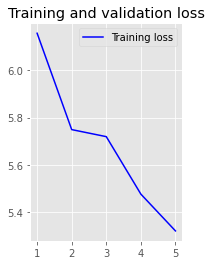

In [ ]:
plot_history(history)

Примеры результатов метрик (общие выводы должны будут написаны в файле readme)

в кратце df_test_array содержит метрики для каждой строки в тестовом наборе, df_test_array_summary усредненное для всей эпохи. Разуменее всего смотреть на df_test_array_summary, конкретнее на поля error_count_mean(среднее число ошибок) и bleu_score_mean(метрика bleu для сгенерированных предсказаний)


In [ ]:
callback_training.df_test_array

bleu_score  ...                                          reference
0       0.614788  ...  сколько нужно ходить, чтобы не болеть. а бегат...
1       0.840896  ...  в сингапуре голодный кабан устроил гоп-стоп. о...
2       0.648139  ...  сноуден уже постит мемы про наташу, котов и со...
3       0.000000  ...  американка выкрала из римского музея кусок мра...
4       0.707107  ...  грустить после рождения ребенка это нормально....
...          ...  ...                                                ...
2120    0.549100  ...  шесть дней назад в приморье прошел ледяной дож...
2121    0.000000  ...  мэрия москвы заказала непрерывный мониторинг а...
2122    0.000000  ...  алтайский край один из лидеров по росту смертн...
2123    0.485492  ...  ужасно хочется, чтобы вторая волна скорее зако...
2124    0.000000  ...  даниил усыновил подростка, переехал в эстонию ...

[2125 rows x 6 columns]

In [ ]:
callback_training.df_test_array_summary

bleu_score_mean  epoch  error_count_mean  loss_in_training
0          0.314277    0.0          6.141176          5.988673
1          0.208047    1.0          6.247059          5.750668
2          0.184460    2.0          4.847059          5.673398
3          0.140318    3.0          6.294118          5.185256
4          0.217443    4.0          7.176471          4.702508
5          0.204064    5.0          5.952941          4.453860
6          0.243663    6.0          6.505882          4.237849
7          0.286795    7.0          6.388235          4.038369
8          0.159932    8.0          4.952941          3.853289
9          0.224232    9.0          4.764706          3.684806
10         0.294572   10.0          6.270588          3.538846
11         0.164080   11.0          4.258824          3.413610
12         0.257420   12.0          4.635294          3.306355
13         0.266635   13.0          4.000000          3.212638
14         0.288493   14.0          4.647059          3.133255
15         0.240808   15.0          4.447059          3.062440
16         0.304124   16.0          5.494118          3.001677
17         0.287617   17.0          4.188235          2.948127
18         0.199719   18.0          3.670588          2.901453
19         0.162732   19.0          4.811765          2.856723
20         0.237875   20.0          4.023529          2.817770
21         0.267841   21.0          3.929412          2.781073
22         0.246098   22.0          3.600000          2.747845
23         0.251849   23.0          4.058824          2.719303
24         0.196031   24.0          4.635294          2.688521

Записываем результаты исследования

In [ ]:
callback_training.df_test_array.to_csv('2-gram_encode_512_model_1024_512_ltsm_text.csv')
callback_training.df_test_array_summary.to_csv('2-gram_encode_512_model_1024_512_ltsm_sumary.csv')

Сохраняем модель (вес в байтах)

In [ ]:
model.save_weights('model_for_docker_weights_ruki_ai_test_second_model_n_gram')
statinfo = os.stat('model_for_docker_weights_ruki_ai_test_second_model_n_gram.data-00000-of-00001')
statinfo.st_size